In [1]:
import pandas as pd
import matplotlib
import json 
import os.path
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
# from lnc import MI
# import entropy_estimators as ee
# import thoth.thoth as thoth
# from mutual_info import mutual_information
from pyinform.mutualinfo import mutual_info
from pyinform.transferentropy import transfer_entropy

plt.style.use('seaborn-whitegrid')
%matplotlib inline  

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#filter by coin
def get_coin_activity(c):
    coin_repos_df = repo_df[[c in x for x in repo_df['extension.socialsim_keywords']]]
    events_coin_df = events_df[events_df.repo_id.isin(coin_repos_df['repo_name'])]
    events_coin_df.loc[:,'timestamp'] = pd.to_datetime(events_coin_df['timestamp'] )
    events_coin_df.loc[:,'timestamp'] = events_coin_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))
    events_coin_df = events_coin_df[events_coin_df.event.isin(['CreateEvent','ForkEvent','WatchEvent'])]
    events_coin_df['timestamp'] = pd.to_datetime(events_coin_df['timestamp'] )

    time_series = events_coin_df.groupby('timestamp',as_index=False)['event'].count()
    time_series.set_index('timestamp', inplace=True)
    time_series=time_series['event']
    #fill missing dates with 0
    all_days = pd.date_range(time_series.index.min(), time_series.index.max(), freq='D')
    time_series = time_series.reindex(all_days,fill_value=0)

    return time_series

In [4]:
#prices
def get_prices(coin, start_date, end_date):
    coins_df = pd.read_csv(data_folder/"crypto-markets.csv") 
    coins_df = coins_df[coins_df.symbol==coin]
    coins_df['date'] = pd.to_datetime(coins_df['date'])
    coins_df = coins_df[(coins_df.date >= start_date) & (coins_df.date <= end_date)]
    coins_df.set_index('date', inplace=True)
    coins_df = coins_df['close']
#     coins_df.plot()
    return coins_df

In [5]:
def plot_corr_ext(df_results, p_sample,label):
    df1 = df_results[df_results.coin==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['corr'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2, label=label)
    y_q1 = [df_q1['corr'][p] for p in p_sample]
    y_q3 = [df_q3['corr'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y


def plot_mi_ext(df_results, p_sample,label):
    df1 = df_results[df_results.coin==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['mi'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2, label=label)
    y_q1 = [df_q1['mi'][p] for p in p_sample]
    y_q3 = [df_q3['mi'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y


def plot_mi_ext2(df_results, p_sample,label):
    df1 = df_results[df_results.coin==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['mi'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2, label=label)
    y_q1 = [df_q1['mi'][p] for p in p_sample]
    y_q3 = [df_q3['mi'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    plt.legend( ncol=1)
    
    return x,y


def plot_cov_ext(df_results, p_sample,label):
    df1 = df_results[df_results.coin==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['cov'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2, label=label)
    y_q1 = [df_q1['cov'][p] for p in p_sample]
    y_q3 = [df_q3['cov'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

def plot_cov_ext_norm(df_results, p_sample,label):
    df1 = df_results[df_results.coin==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = [1.-p for p in p_sample]
    y = [df['ratio'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2, label=label)
    y_q1 = [df_q1['ratio'][p] for p in p_sample]
    y_q3 = [df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

# Main

In [6]:
data_folder = Path("Data/Crypto/")
result_folder = Path("Results/crypto/")
fig_folder = Path("Figures/crypto/")

events_df = pd.read_csv(data_folder/'repos_activity.csv')
repo_df= pd.read_csv(data_folder/'crypto_repos.csv')

In [7]:
#statitistics of data
coins = ['BTC','LTC','XMR','XRP']
events_coin_df = pd.DataFrame()
for c in coins:
    coin_repos_df = repo_df[[c in x for x in repo_df['extension.socialsim_keywords']]]
    df = events_df[events_df.repo_id.isin(coin_repos_df['repo_name'])]
    df['coin'] = c
    events_coin_df = events_coin_df.append(df)

print("# of repos =", len(events_coin_df.repo_id.unique()))
print("# of users =", len(events_coin_df.user_id.unique()) )
print("# of events =", len(events_coin_df.user_id) )
events_coin_df.head()

# of repos = 2039
# of users = 5510
# of events = 44605


<ipython-input-7-65dffddced0b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coin'] = c


,timestamp,event,user_id,repo_id,coin
5,2015-01-01T00:25:45Z,ForkEvent,WK5cJERlDDgDJVoEDcK_lQ,zVseSUfjBEdseIzUdPtXmg/zVseSUfjBEdseIzUdPtXmg,BTC
7,2015-01-01T00:37:07Z,GollumEvent,psz6_EYYjOCcUNSg9RKviQ,Z3ECKHTLHQoTTHWjjlGDEA/Z3ECKHTLHQoTTHWjjlGDEA,BTC
9,2015-01-01T00:37:55Z,GollumEvent,psz6_EYYjOCcUNSg9RKviQ,Z3ECKHTLHQoTTHWjjlGDEA/Z3ECKHTLHQoTTHWjjlGDEA,BTC
10,2015-01-01T00:40:18Z,PushEvent,kpfjHqKAULqJNeN3sIfqfg,kpfjHqKAULqJNeN3sIfqfg/cQv1CxjKLSik5wxgA49GcQ,BTC
12,2015-01-01T00:40:36Z,GollumEvent,psz6_EYYjOCcUNSg9RKviQ,Z3ECKHTLHQoTTHWjjlGDEA/Z3ECKHTLHQoTTHWjjlGDEA,BTC


In [8]:
events_coin_df['timestamp'] = pd.to_datetime(events_coin_df['timestamp']).dt.date
events_coin_df.groupby(['coin','repo_id']).count().reset_index().groupby(['coin']).describe()

timestamp                                                         event  \
         count        mean          std  min  25%  50%   75%     max   count   
coin                                                                           
BTC     1965.0   20.381679   138.256535  1.0  1.0  3.0   9.0  4965.0  1965.0   
LTC      137.0    8.919708    19.186415  1.0  1.0  2.0   8.0   163.0   137.0   
XMR       15.0   24.666667    55.818157  1.0  2.5  5.0  12.5   217.0    15.0   
XRP        7.0  423.285714  1114.617829  1.0  1.0  2.0   3.5  2951.0     7.0   

                  ...               user_id                                \
            mean  ...   75%     max   count        mean          std  min   
coin              ...                                                       
BTC    20.381679  ...   9.0  4965.0  1965.0   20.381679   138.256535  1.0   
LTC     8.919708  ...   8.0   163.0   137.0    8.919708    19.186415  1.0   
XMR    24.666667  ...  12.5   217.0    15.0   24.666667    55.818157  1.0   
XRP   423.285714  ...   3.5  2951.0     7.0  423.285714  1114.617829  1.0   

                              
      25%  50%   75%     max  
coin                          
BTC   1.0  3.0   9.0  4965.0  
LTC   1.0  2.0   8.0   163.0  
XMR   2.5  5.0  12.5   217.0  
XRP   1.0  2.0   3.5  2951.0  

[4 rows x 24 columns]

In [9]:
coins = ['BTC','LTC','XMR','XRP']
samples = 1000
p_sample = [1.0, 0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
results = []
for c in coins:
    print(c)
    ts_activity = get_coin_activity(c)
    start_date = ts_activity.index.min()
    end_date = ts_activity.index.max()
    ts_price = get_prices(c, start_date, end_date)
#     ts_activity.plot()
    ts_activity = ts_activity
    cov_original = np.abs(ts_activity.cov(ts_price))
    print(cov_original, ts_activity.mean())
    for i in range(samples):
        for p in p_sample:
            ts_sample = ts_activity.apply(lambda x: np.random.binomial(x, p, 1)[0])        
            coef = np.abs(ts_sample.corr(ts_price))
            cov = np.abs(ts_sample.cov(ts_price))
#             mi = MI.mi_LNC([ts_sample,ts_price],k=2,base=2 ,alpha=0.25)
#             mi = MI.mi_Kraskov([ts_sample,ts_price],k=2,base=np.exp(1),intens=1e-10)
#             mi = ee.mi(ts_sample,ts_price)
            mi = mutual_info(ts_sample,ts_price)
#             mi =  mutual_information((ts_sample.values, ts_price.values), k=2)
#             mi = M.knn_mutual_information(ts_sample, ts_price, k = 10)
            results.append([c,p,coef,cov,cov_original,mi])
            
results_df = pd.DataFrame.from_records(results,columns=['coin','sample_rate', 'corr', 'cov','cov_original','mi'])
results_df['ratio'] = results_df['cov']/results_df['cov_original']

/Users/aabeliuk/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


BTC


/Users/aabeliuk/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


107.23780005107243 97.15730337078652
LTC
0.07997701736465777 4.797752808988764
XMR
0.03528528383554648 0.7752808988764045
XRP
0.00033334156217345863 1.0340909090909092


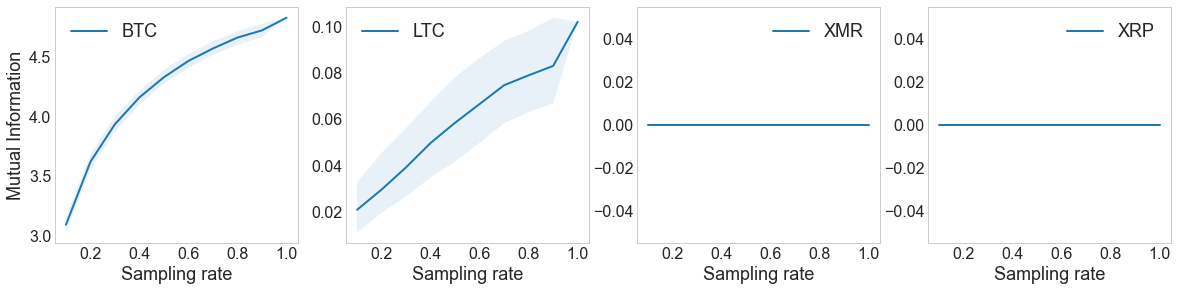

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
yy=[]
xx=[]
i=0
for c in results_df.coin.unique():
    plt.subplot(4, 4, i + 1)
    i+=1
    x,y = plot_mi_ext2(results_df, p_sample, c)
    plt.xlabel('Sampling rate')
    if i==1:
        plt.ylabel("Mutual Information")
    plt.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
    #removing top and right borders
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
# plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( ncol=1)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim(0,0.5)

# plt.xlabel('Sampling rate')
# plt.ylabel("Mutual Information")
plt.savefig('Figures/crypto_mi.pdf', bbox_inches='tight')


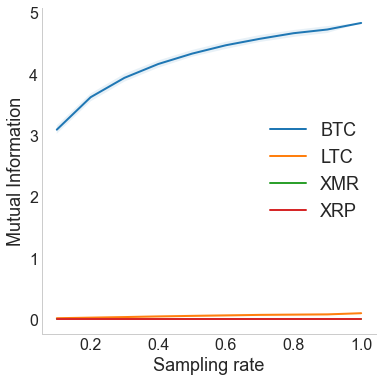

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
for c in results_df.coin.unique():
    x,y = plot_mi_ext(results_df, p_sample, c)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
# plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

plt.legend( ncol=1)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim(0,0.5)
# plt.yscale('log')

plt.xlabel('Sampling rate')
plt.ylabel("Mutual Information")
plt.savefig('Figures/crypto_mi.pdf', bbox_inches='tight')


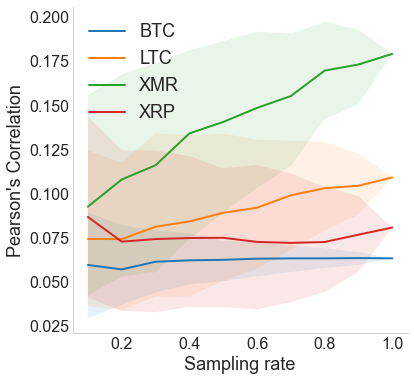

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
for c in results_df.coin.unique():
    x,y = plot_corr_ext(results_df, p_sample, c)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
# plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

plt.legend( ncol=1)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlim(0,0.95)

plt.xlabel('Sampling rate')
plt.ylabel("Pearson's Correlation")
plt.savefig('Figures/crypto_corr.pdf', bbox_inches='tight')


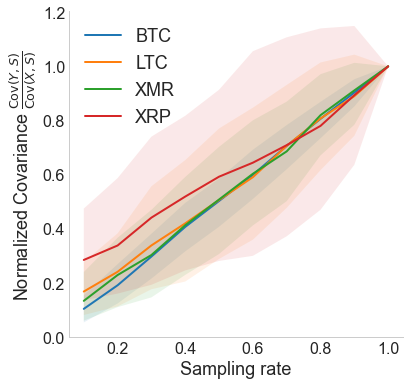

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
for c in results_df.coin.unique():
    x,y = plot_cov_ext_norm(results_df, p_sample, c)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
# plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

plt.legend( ncol=1)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlim(0,1.)

# plt.yscale('log')
plt.xlabel('Sampling rate')
plt.ylabel(r'Normalized Covariance $\frac{\mathrm{Cov}(Y,S)}{\mathrm{Cov}(X,S)}$')
plt.savefig('Figures/crypto_cov_norm.pdf', bbox_inches='tight')


Text(0, 0.5, 'Covariance $\\mathrm{Cov}(Y,S)$')

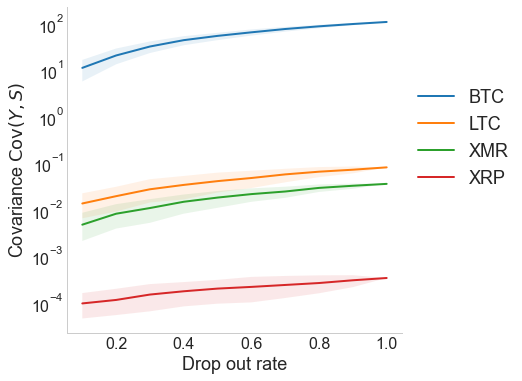

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
for c in results_df.coin.unique():
    x,y = plot_cov_ext(results_df, p_sample, c)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
# plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( ncol=1)
plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlim(0,1.)

plt.yscale('log')
plt.xlabel('Drop out rate')
plt.ylabel(r'Covariance $\mathrm{Cov}(Y,S)$')
# plt.savefig('Figures/crypto_cov.pdf', bbox_inches='tight')
